In [15]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from textblob import TextBlob
import matplotlib.pyplot as plt

import os
def load_data(path, label):
    reviews = []
    for filename in os.listdir(path):
        with open(os.path.join(path, filename), 'r', encoding='utf-8') as f:
            reviews.append(f.read())
    return pd.DataFrame({'review': reviews, 'label': label})

train_pos_path = '../data/raw/aclImdb/train/pos'
train_neg_path = '../data/raw/aclImdb/train/neg'
train_pos = load_data(train_pos_path, 'positive')
train_neg = load_data(train_neg_path, 'negative')
train_data = pd.concat([train_pos, train_neg], ignore_index=True)

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab', download_dir='~/nltk_data')
nltk.data.path.append('~/nltk_data')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    try:
        text = re.sub(r'<[^>]+>', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        tokens = word_tokenize(text.lower())
        tokens = [word for word in tokens if word not in stop_words and word]
        return ' '.join(tokens)
    except Exception as e:
        print(f"Error preprocessing text: {e}")
        return ""

train_data['clean_review'] = train_data['review'].apply(preprocess_text)
y = train_data['label'].map({'positive': 1, 'negative': 0})

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rashidkarimov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rashidkarimov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to ~/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [16]:
# Cell 2: Load and Preprocess Data (Updated)
import os
def load_data(path, label):
    reviews = []
    for filename in os.listdir(path):
        with open(os.path.join(path, filename), 'r', encoding='utf-8') as f:
            reviews.append(f.read())
    return pd.DataFrame({'review': reviews, 'label': label})

train_pos_path = '../data/raw/aclImdb/train/pos'
train_neg_path = '../data/raw/aclImdb/train/neg'
train_pos = load_data(train_pos_path, 'positive')
train_neg = load_data(train_neg_path, 'negative')
train_data = pd.concat([train_pos, train_neg], ignore_index=True)

# Sample the dataset to 5,000 reviews for efficiency and reset index
train_data = train_data.sample(5000, random_state=42).reset_index(drop=True)

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab', download_dir='~/nltk_data')
nltk.data.path.append('~/nltk_data')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    try:
        text = re.sub(r'<[^>]+>', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        tokens = word_tokenize(text.lower())
        tokens = [word for word in tokens if word not in stop_words and word]
        return ' '.join(tokens)
    except Exception as e:
        print(f"Error preprocessing text: {e}")
        return ""

train_data['clean_review'] = train_data['review'].apply(preprocess_text)
y = train_data['label'].map({'positive': 1, 'negative': 0})

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rashidkarimov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rashidkarimov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to ~/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [17]:
# Cell 3: Engineer Additional Features
vectorizer = TfidfVectorizer(max_features=3000)  # Reduced from 5000 for speed
X_text = vectorizer.fit_transform(train_data['clean_review'])

# Add review length and sentiment score as features
train_data['review_length'] = train_data['clean_review'].apply(lambda x: len(x.split()))
train_data['sentiment_score'] = train_data['clean_review'].apply(lambda x: TextBlob(x).sentiment.polarity)

X_metadata = np.array(train_data[['review_length', 'sentiment_score']])
X = np.hstack((X_text.toarray(), X_metadata))  # Concatenate horizontally
print("Combined feature matrix shape:", X.shape)

Combined feature matrix shape: (5000, 3002)


In [18]:
# Cell 4: Build Ensemble Model
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Reduced complexity for faster execution
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)  # Reduced from 100
gb_model = GradientBoostingClassifier(n_estimators=50, random_state=42)  # Reduced from 100

ensemble = VotingClassifier(estimators=[('rf', rf_model), ('gb', gb_model)], voting='soft')
ensemble.fit(X_train, y_train)
y_pred_ensemble = ensemble.predict(X_val)

Ensemble Validation Accuracy: 0.814

Ensemble Classification Report:
              precision    recall  f1-score   support

    negative       0.81      0.81      0.81       484
    positive       0.82      0.82      0.82       516

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000


Cross-Validation Scores: [0.79664067 0.81643671 0.81332533]
Mean CV Accuracy: 0.8088009048850494 ± 0.00869189759181332


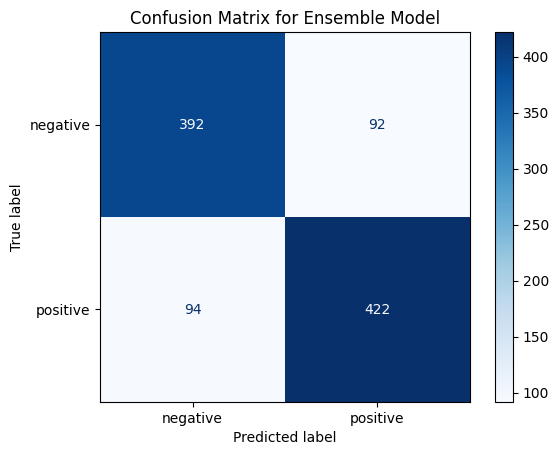

In [19]:
# Cell 5: Evaluate and Cross-Validate Ensemble
# Evaluate ensemble
ensemble_accuracy = accuracy_score(y_val, y_pred_ensemble)
print("Ensemble Validation Accuracy:", ensemble_accuracy)

print("\nEnsemble Classification Report:")
print(classification_report(y_val, y_pred_ensemble, target_names=['negative', 'positive']))

# Use 3-fold cross-validation for faster execution
cv_scores = cross_val_score(ensemble, X, y, cv=3, scoring='accuracy')
print("\nCross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean(), "±", cv_scores.std())

# Confusion Matrix
cm_ensemble = confusion_matrix(y_val, y_pred_ensemble)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ensemble, display_labels=['negative', 'positive'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Ensemble Model')
plt.savefig('../output/figures/confusion_matrix_ensemble.png')
plt.show()

In [20]:
# Cell 6: Perform Detailed Error and Feature Analysis
# Identify misclassified reviews
val_data = train_data.iloc[y_val.index].copy()
val_data['predicted_ensemble'] = y_pred_ensemble

misclassified_ensemble = val_data[val_data['label'].map({'positive': 1, 'negative': 0}) != y_pred_ensemble]

print("\nSample Misclassified Reviews (Ensemble):")
for _, row in misclassified_ensemble.head(5).iterrows():
    print(f"\nReview: {row['clean_review'][:200]}...")
    print(f"True Label: {row['label']}")
    print(f"Predicted Label: {'positive' if row['predicted_ensemble'] == 1 else 'negative'}")
    print(f"Review Length: {row['review_length']}")
    print(f"Sentiment Score: {row['sentiment_score']:.2f}")

# Feature importance from Random Forest (approximate for TF-IDF + metadata)
rf_feature_importance = rf_model.fit(X_train, y_train).feature_importances_
feature_names = list(vectorizer.get_feature_names_out()) + ['review_length', 'sentiment_score']
top_features = np.argsort(rf_feature_importance)[-10:]  # Top 10 features
print("\nTop 10 Most Important Features (Random Forest):")
for idx in top_features:
    print(f"{feature_names[idx]}: {rf_feature_importance[idx]:.4f}")


Sample Misclassified Reviews (Ensemble):

Review: enjoyed jean arthur devil miss jones interest peaked tried sitting secondstring screwball outing investigation death jockeybut didnt make end arthur photographed gauzy moviemagazine fashion either wan...
True Label: negative
Predicted Label: positive
Review Length: 79
Sentiment Score: 0.16

Review: marquis de sade egyptian archaeology mermaid worshipping cults tobe hooper tries answer question one weird little filmgenie young cutie visits nerdy archaeology father alexandria egypt genie gets caug...
True Label: positive
Predicted Label: negative
Review Length: 218
Sentiment Score: 0.08

Review: jackie chans best film personal favourite disappointing us made protector directed james glickenhaus jackie took concept placed slap bang hong kong also probably jackies violent movie audience cringin...
True Label: positive
Predicted Label: negative
Review Length: 88
Sentiment Score: -0.01

Review: movie represents times made much original suppo